## 1. 环境设置与数据加载

In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 设置matplotlib中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

print("环境配置完成")
print("已导入神经网络模块 (MLPClassifier)")

环境配置完成
已导入神经网络模块 (MLPClassifier)


In [2]:
# 定义交叉验证策略
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 定义评估指标
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

# 全局结果字典
if 'results' not in locals():
    results = {}

def evaluate_and_print_metrics(best_model, model_name, X, y, cv):
    """
    使用最佳模型进行交叉验证，并打印指定指标
    """
    print(f"正在评估最佳 {model_name} 模型...")
    cv_results = cross_validate(best_model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    # 提取指标
    mean_auc = cv_results['test_roc_auc'].mean()
    std_auc = cv_results['test_roc_auc'].std()
    mean_acc = cv_results['test_accuracy'].mean()
    mean_f1 = cv_results['test_f1'].mean()
    mean_time = cv_results['fit_time'].mean()
    
    # 打印结果
    print(f"  -> ROC-AUC:   {mean_auc:.4f} (±{std_auc:.4f})")
    print(f"  -> Accuracy:  {mean_acc:.4f}")
    print(f"  -> F1-Score:  {mean_f1:.4f}")
    print(f"  -> 训练时间:   {mean_time:.4f} 秒")
    
    # 返回结果字典用于汇总
    return {
        'test_roc_auc': mean_auc,
        'test_roc_auc_std': std_auc,
        'test_accuracy': mean_acc,
        'test_f1': mean_f1,
        'fit_time': mean_time,
        'test_precision': cv_results['test_precision'].mean(), 
        'test_recall': cv_results['test_recall'].mean()        
    }

def plot_param_effect(grid_search, param_name, model_name):
    """绘制参数影响图"""
    results_df = pd.DataFrame(grid_search.cv_results_)
    param_col = f'param_{param_name}'
    
    if param_col not in results_df.columns: return

    results_df[param_col] = results_df[param_col].astype(str)
    # ----------------

    plt.figure(figsize=(8, 4))
    
    try:
        results_df[param_col] = pd.to_numeric(results_df[param_col])
        is_numeric = True
    except ValueError:
        is_numeric = False

    if is_numeric:
        sns.lineplot(data=results_df, x=param_col, y='mean_test_score', marker='o')
    else:
        sns.barplot(data=results_df, x=param_col, y='mean_test_score', palette='viridis')
        
    plt.title(f'{model_name}: {param_name} 对 ROC-AUC 的影响', fontsize=12)
    plt.xlabel(param_name)
    plt.ylabel('Mean ROC-AUC')
    plt.grid(True, alpha=0.3)
    plt.show()

In [3]:
# 读取数据
train_df = pd.read_csv('../data/train.csv')
test_in_domain = pd.read_csv('../data/test_in_domain.csv')
test_cross_domain = pd.read_csv('../data/test_cross_domain.csv')

# 分离训练集的特征和标签
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']

# 测试集只有特征,没有标签
X_test_in = test_in_domain  # 不需要drop label,因为测试集没有label列
X_test_cross = test_cross_domain  # 不需要drop label,因为测试集没有label列

print(f"训练集形状: {X_train.shape}")
print(f"训练集标签形状: {y_train.shape}")
print(f"域内测试集形状: {X_test_in.shape}")
print(f"跨域测试集形状: {X_test_cross.shape}")
print(f"标签分布:\n{y_train.value_counts()}")
print("数据加载完成!")


训练集形状: (196, 12700)
训练集标签形状: (196,)
域内测试集形状: (84, 12700)
跨域测试集形状: (200, 12700)
标签分布:
label
1    126
0     70
Name: count, dtype: int64
数据加载完成!


## 2. 数据预处理与特征工程

In [4]:
# 步骤1: 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_in_scaled = scaler.transform(X_test_in)
X_test_cross_scaled = scaler.transform(X_test_cross)

print("数据标准化完成")
print(f"训练集均值: {X_train_scaled.mean():.6f}, 标准差: {X_train_scaled.std():.6f}")

数据标准化完成
训练集均值: -0.000000, 标准差: 1.000000


In [5]:
# 步骤2: 方差过滤 (移除低方差特征)
variance_threshold = 0.01
selector_variance = VarianceThreshold(threshold=variance_threshold)
X_train_var = selector_variance.fit_transform(X_train_scaled)
X_test_in_var = selector_variance.transform(X_test_in_scaled)
X_test_cross_var = selector_variance.transform(X_test_cross_scaled)

n_features_removed = X_train_scaled.shape[1] - X_train_var.shape[1]
print(f"\n方差过滤 (阈值={variance_threshold})")
print(f"移除特征数: {n_features_removed}")
print(f"剩余特征数: {X_train_var.shape[1]}")


方差过滤 (阈值=0.01)
移除特征数: 0
剩余特征数: 12700


In [6]:
# 步骤3: 单变量特征选择 (ANOVA F-score)
# 选择前500个最佳特征 (可调整)
k_best = min(500, X_train_var.shape[1])
selector_kbest = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = selector_kbest.fit_transform(X_train_var, y_train)
X_test_in_selected = selector_kbest.transform(X_test_in_var)
X_test_cross_selected = selector_kbest.transform(X_test_cross_var)

print(f"\n特征选择 (SelectKBest, k={k_best})")
print(f"选择特征数: {X_train_selected.shape[1]}")
print(f"新的样本/特征比: {X_train_selected.shape[0] / X_train_selected.shape[1]:.4f}")


特征选择 (SelectKBest, k=500)
选择特征数: 500
新的样本/特征比: 0.3920


In [7]:
# 可选: PCA降维 (保留95%方差)
use_pca = False  # 设置为True启用PCA

if use_pca:
    pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
    X_train_final = pca.fit_transform(X_train_selected)
    X_test_in_final = pca.transform(X_test_in_selected)
    X_test_cross_final = pca.transform(X_test_cross_selected)
    print(f"\nPCA降维 (保留95%方差)")
    print(f"主成分数: {X_train_final.shape[1]}")
    print(f"解释方差比: {pca.explained_variance_ratio_.sum():.4f}")
else:
    X_train_final = X_train_selected
    X_test_in_final = X_test_in_selected
    X_test_cross_final = X_test_cross_selected
    print("\n跳过PCA降维，直接使用选择后的特征")

print(f"\n最终特征维度: {X_train_final.shape[1]}")


跳过PCA降维，直接使用选择后的特征

最终特征维度: 500


## 3. 模型训练与交叉验证

In [8]:
# 定义评估指标
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

# 设置交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("交叉验证设置: 5折分层K折")

交叉验证设置: 5折分层K折


In [9]:
# 初始化结果字典
results = {}
print("准备分别训练8个模型(包括神经网络),每个模型单独调优...")


准备分别训练8个模型(包括神经网络),每个模型单独调优...


### 3.1 Logistic Regression - 逻辑回归

模型 1/8: Logistic Regression (调参)
最佳参数: {'C': 100, 'solver': 'liblinear'}
正在评估最佳 Logistic Regression 模型...
  -> ROC-AUC:   0.9500 (±0.0294)
  -> Accuracy:  0.8162
  -> F1-Score:  0.8409
  -> 训练时间:   0.0106 秒


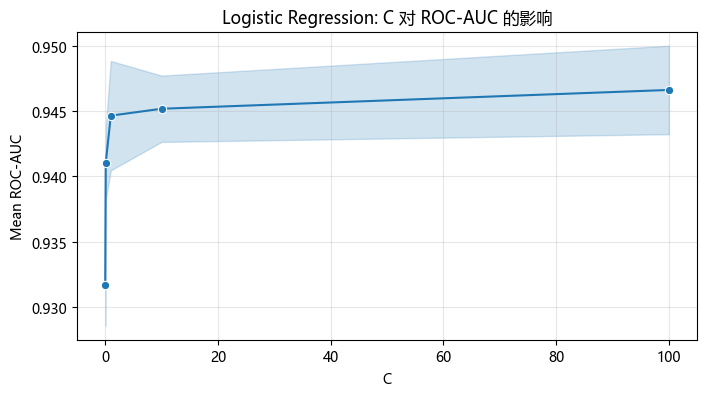

In [10]:
print("="*60)
print("模型 1/8: Logistic Regression (调参)")
print("="*60)

# 1. 参数网格
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'solver': ['lbfgs', 'liblinear']
}

# 2. 网格搜索
lr_grid = GridSearchCV(
    LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'),
    param_grid, cv=cv, scoring='roc_auc', n_jobs=-1
)
lr_grid.fit(X_train_final, y_train)

print(f"最佳参数: {lr_grid.best_params_}")

# 3. 评估最佳模型并输出指标
metrics = evaluate_and_print_metrics(lr_grid.best_estimator_, 'Logistic Regression', X_train_final, y_train, cv)
results['Logistic Regression'] = metrics # 保存结果

# 4. 可视化参数影响
plot_param_effect(lr_grid, 'C', 'Logistic Regression')

### 3.2 SVM (Linear Kernel) - 线性支持向量机


模型 2/8: SVM (Linear) (调参)
最佳参数: {'C': 0.1}
正在评估最佳 SVM (Linear) 模型...
  -> ROC-AUC:   0.9360 (±0.0225)
  -> Accuracy:  0.8676
  -> F1-Score:  0.8960
  -> 训练时间:   0.0118 秒


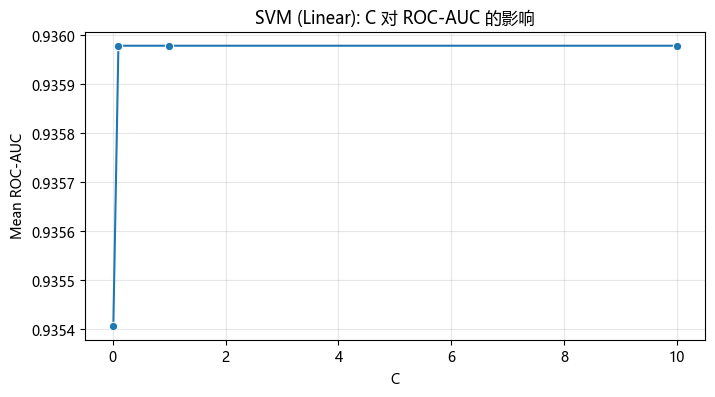

In [11]:
print("\n" + "="*60)
print("模型 2/8: SVM (Linear) (调参)")
print("="*60)

param_grid = {'C': [0.01, 0.1, 1, 10]}

svm_lin_grid = GridSearchCV(
    SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced', max_iter=3000),
    param_grid, cv=cv, scoring='roc_auc', n_jobs=-1
)
svm_lin_grid.fit(X_train_final, y_train)

print(f"最佳参数: {svm_lin_grid.best_params_}")

metrics = evaluate_and_print_metrics(svm_lin_grid.best_estimator_, 'SVM (Linear)', X_train_final, y_train, cv)
results['SVM (Linear)'] = metrics

plot_param_effect(svm_lin_grid, 'C', 'SVM (Linear)')

### 3.3 SVM (RBF Kernel) - RBF核支持向量机


模型 3/8: SVM (RBF) (调参)
最佳参数: {'C': 10, 'gamma': 'scale'}
正在评估最佳 SVM (RBF) 模型...
  -> ROC-AUC:   0.9264 (±0.0247)
  -> Accuracy:  0.8321
  -> F1-Score:  0.8744
  -> 训练时间:   0.0166 秒


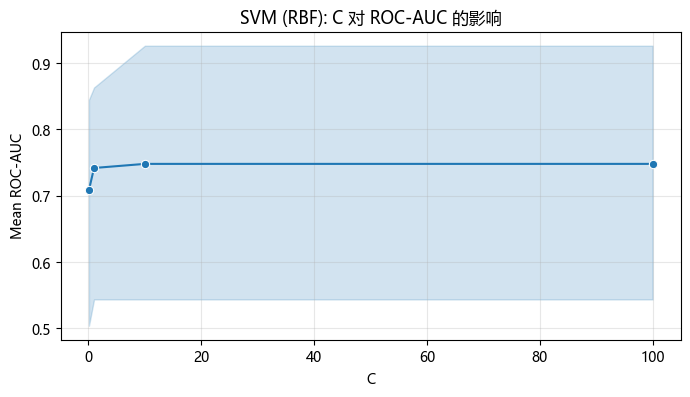

In [12]:
print("\n" + "="*60)
print("模型 3/8: SVM (RBF) (调参)")
print("="*60)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1]
}

svm_rbf_grid = GridSearchCV(
    SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced', max_iter=3000),
    param_grid, cv=cv, scoring='roc_auc', n_jobs=-1
)
svm_rbf_grid.fit(X_train_final, y_train)

print(f"最佳参数: {svm_rbf_grid.best_params_}")

metrics = evaluate_and_print_metrics(svm_rbf_grid.best_estimator_, 'SVM (RBF)', X_train_final, y_train, cv)
results['SVM (RBF)'] = metrics

plot_param_effect(svm_rbf_grid, 'C', 'SVM (RBF)')

### 3.4 Random Forest - 随机森林


模型 4/8: Random Forest (调参)
最佳参数: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
正在评估最佳 Random Forest 模型...
  -> ROC-AUC:   0.8556 (±0.0526)
  -> Accuracy:  0.7605
  -> F1-Score:  0.8374
  -> 训练时间:   0.2601 秒


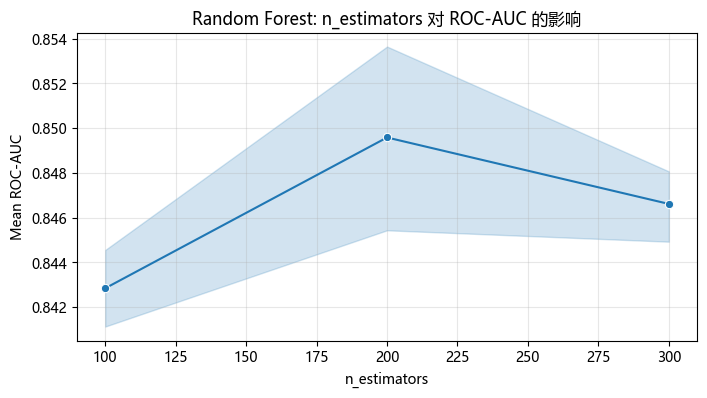

In [13]:
print("\n" + "="*60)
print("模型 4/8: Random Forest (调参)")
print("="*60)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_grid, cv=cv, scoring='roc_auc', n_jobs=-1
)
rf_grid.fit(X_train_final, y_train)

print(f"最佳参数: {rf_grid.best_params_}")

metrics = evaluate_and_print_metrics(rf_grid.best_estimator_, 'Random Forest', X_train_final, y_train, cv)
results['Random Forest'] = metrics

plot_param_effect(rf_grid, 'n_estimators', 'Random Forest')

### 3.5 Gradient Boosting - 梯度提升


模型 5/8: Gradient Boosting (调参)
最佳参数: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
正在评估最佳 Gradient Boosting 模型...
  -> ROC-AUC:   0.8027 (±0.0474)
  -> Accuracy:  0.7249
  -> F1-Score:  0.8053
  -> 训练时间:   3.5601 秒


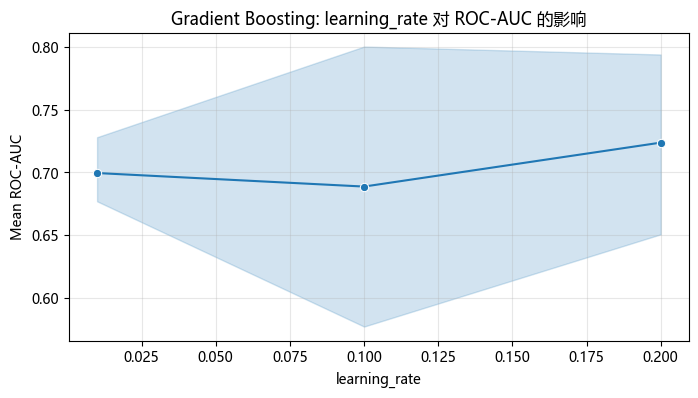

In [14]:
print("\n" + "="*60)
print("模型 5/8: Gradient Boosting (调参)")
print("="*60)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid, cv=cv, scoring='roc_auc', n_jobs=-1
)
gb_grid.fit(X_train_final, y_train)

print(f"最佳参数: {gb_grid.best_params_}")

metrics = evaluate_and_print_metrics(gb_grid.best_estimator_, 'Gradient Boosting', X_train_final, y_train, cv)
results['Gradient Boosting'] = metrics

plot_param_effect(gb_grid, 'learning_rate', 'Gradient Boosting')

### 3.6 K-Nearest Neighbors - K近邻


模型 6/8: K-Nearest Neighbors (调参)
最佳参数: {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
正在评估最佳 K-Nearest Neighbors 模型...
  -> ROC-AUC:   0.8193 (±0.0586)
  -> Accuracy:  0.7096
  -> F1-Score:  0.8058
  -> 训练时间:   0.0010 秒


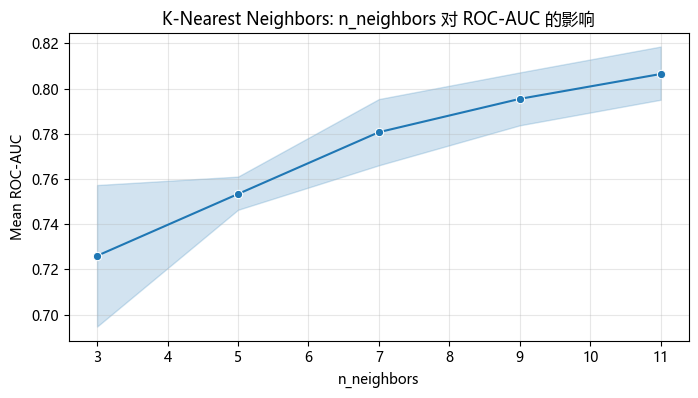

In [15]:
print("\n" + "="*60)
print("模型 6/8: K-Nearest Neighbors (调参)")
print("="*60)

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    param_grid, cv=cv, scoring='roc_auc', n_jobs=-1
)
knn_grid.fit(X_train_final, y_train)

print(f"最佳参数: {knn_grid.best_params_}")

metrics = evaluate_and_print_metrics(knn_grid.best_estimator_, 'K-Nearest Neighbors', X_train_final, y_train, cv)
results['K-Nearest Neighbors'] = metrics

plot_param_effect(knn_grid, 'n_neighbors', 'K-Nearest Neighbors')

### 3.7 Naive Bayes - 朴素贝叶斯


模型 7/8: Naive Bayes (调参)
最佳参数: {'var_smoothing': 1e-09}
正在评估最佳 Naive Bayes 模型...
  -> ROC-AUC:   0.8424 (±0.0586)
  -> Accuracy:  0.7303
  -> F1-Score:  0.7753
  -> 训练时间:   0.0016 秒


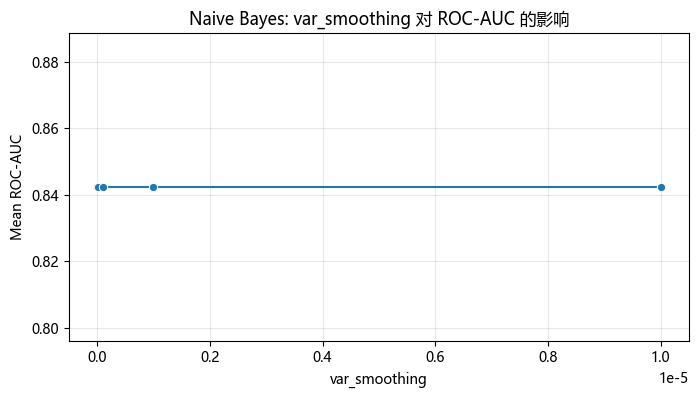

In [16]:
print("\n" + "="*60)
print("模型 7/8: Naive Bayes (调参)")
print("="*60)

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

nb_grid = GridSearchCV(
    GaussianNB(),
    param_grid, cv=cv, scoring='roc_auc', n_jobs=-1
)
nb_grid.fit(X_train_final, y_train)

print(f"最佳参数: {nb_grid.best_params_}")

metrics = evaluate_and_print_metrics(nb_grid.best_estimator_, 'Naive Bayes', X_train_final, y_train, cv)
results['Naive Bayes'] = metrics

plot_param_effect(nb_grid, 'var_smoothing', 'Naive Bayes')

### 3.8 Neural Network (MLP) - 多层感知机神经网络


模型 8/8: Neural Network (MLP) (调参)
最佳参数: {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
正在评估最佳 Neural Network (MLP) 模型...
  -> ROC-AUC:   0.9340 (±0.0311)
  -> Accuracy:  0.8272
  -> F1-Score:  0.8653
  -> 训练时间:   0.0476 秒


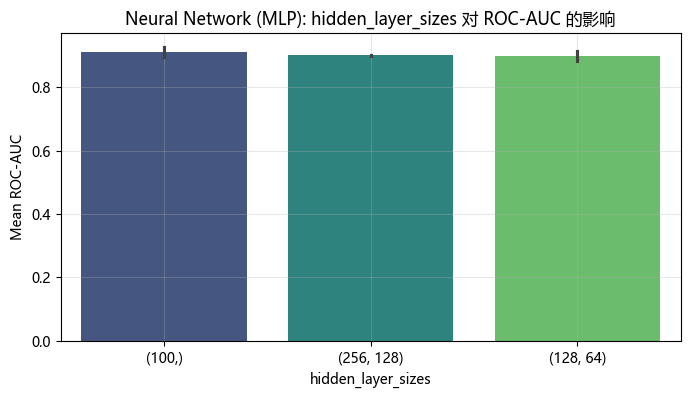

In [17]:
print("\n" + "="*60)
print("模型 8/8: Neural Network (MLP) (调参)")
print("="*60)

param_grid = {
    'hidden_layer_sizes': [(100,), (256, 128), (128, 64)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

mlp_grid = GridSearchCV(
    MLPClassifier(max_iter=500, early_stopping=True, random_state=42),
    param_grid, cv=cv, scoring='roc_auc', n_jobs=1 
)
mlp_grid.fit(X_train_final, y_train)

print(f"最佳参数: {mlp_grid.best_params_}")

metrics = evaluate_and_print_metrics(mlp_grid.best_estimator_, 'Neural Network (MLP)', X_train_final, y_train, cv)
results['Neural Network (MLP)'] = metrics

plot_param_effect(mlp_grid, 'hidden_layer_sizes', 'Neural Network (MLP)')

## 4. 模型性能对比


调参后模型性能对比 (按 ROC-AUC 排序)
                      ROC-AUC  AUC Std  Accuracy  F1-Score  Precision  Recall  \
Logistic Regression    0.9500   0.0294    0.8162    0.8409     0.9356  0.7692   
SVM (Linear)           0.9360   0.0225    0.8676    0.8960     0.9030  0.9040   
Neural Network (MLP)   0.9340   0.0311    0.8272    0.8653     0.8913  0.8566   
SVM (RBF)              0.9264   0.0247    0.8321    0.8744     0.8484  0.9126   
Random Forest          0.8556   0.0526    0.7605    0.8374     0.7517  0.9520   
Naive Bayes            0.8424   0.0586    0.7303    0.7753     0.8379  0.7228   
K-Nearest Neighbors    0.8193   0.0586    0.7096    0.8058     0.7079  0.9369   
Gradient Boosting      0.8027   0.0474    0.7249    0.8053     0.7502  0.8812   

                      Time(s)  
Logistic Regression    0.0106  
SVM (Linear)           0.0118  
Neural Network (MLP)   0.0476  
SVM (RBF)              0.0166  
Random Forest          0.2601  
Naive Bayes            0.0016  
K-Nearest Neighbors 

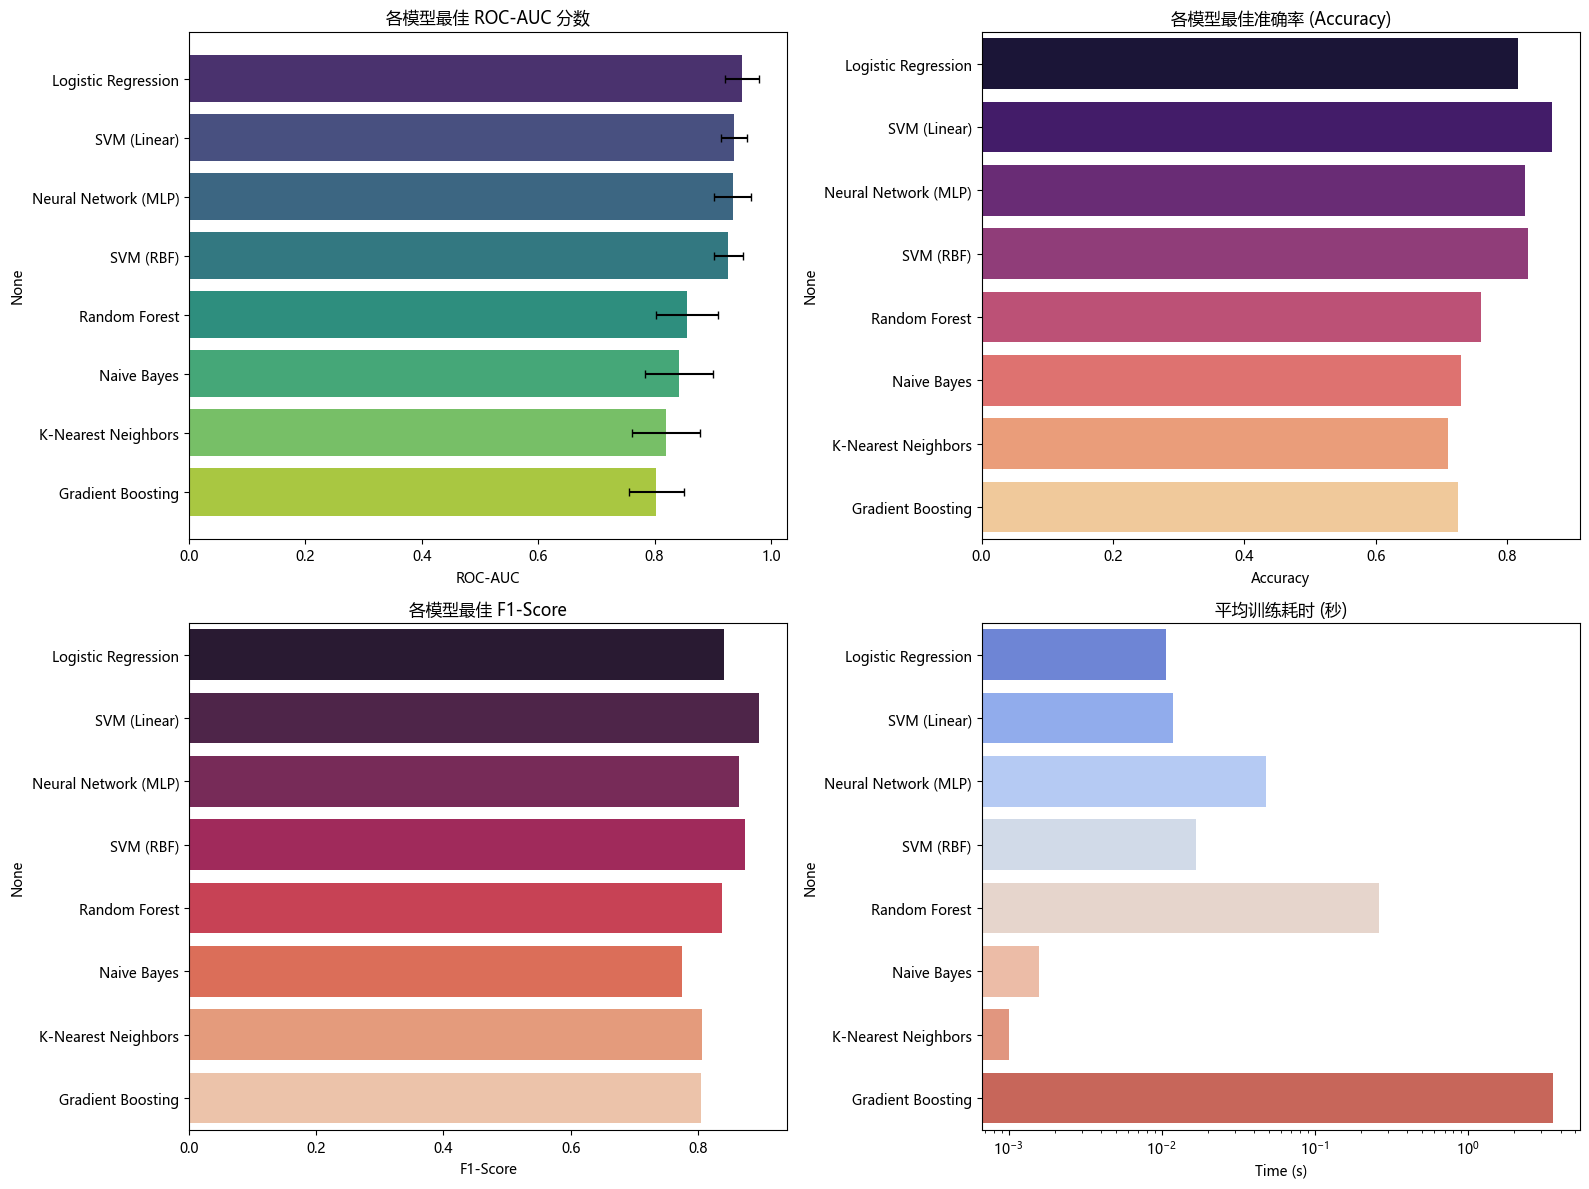


>>> 表现最好的模型是: Logistic Regression
>>> 最佳 ROC-AUC: 0.9500


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame(results).T

# 按 ROC-AUC 降序排序
results_df = results_df.sort_values('test_roc_auc', ascending=False)

print("\n" + "="*80)
print("调参后模型性能对比 (按 ROC-AUC 排序)")
print("="*80)

# 选取展示的列 
display_cols = [
    'test_roc_auc', 'test_roc_auc_std',
    'test_accuracy', 
    'test_f1', 
    'test_precision', 'test_recall',
    'fit_time'
]

# 格式化显示
display_df = results_df[display_cols].copy()
display_df.columns = [
    'ROC-AUC', 'AUC Std', 
    'Accuracy', 
    'F1-Score', 
    'Precision', 'Recall', 
    'Time(s)'
]

print(display_df.round(4))

# -----------------------------------------------------------
# 可视化对比
# -----------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4)

# 1. ROC-AUC 对比 
ax1 = axes[0, 0]
sns.barplot(x=results_df['test_roc_auc'], y=results_df.index, ax=ax1, palette='viridis')
ax1.errorbar(x=results_df['test_roc_auc'], y=range(len(results_df)), 
             xerr=results_df['test_roc_auc_std'], fmt='none', c='black', capsize=3)
ax1.set_title('各模型最佳 ROC-AUC 分数')
ax1.set_xlabel('ROC-AUC')

# 2. Accuracy 对比
ax2 = axes[0, 1]
sns.barplot(x=results_df['test_accuracy'], y=results_df.index, ax=ax2, palette='magma')
ax2.set_title('各模型最佳准确率 (Accuracy)')
ax2.set_xlabel('Accuracy')

# 3. F1-Score 对比
ax3 = axes[1, 0]
sns.barplot(x=results_df['test_f1'], y=results_df.index, ax=ax3, palette='rocket')
ax3.set_title('各模型最佳 F1-Score')
ax3.set_xlabel('F1-Score')

# 4. 训练时间对比 (对数坐标)
ax4 = axes[1, 1]
sns.barplot(x=results_df['fit_time'], y=results_df.index, ax=ax4, palette='coolwarm')
ax4.set_title('平均训练耗时 (秒)')
ax4.set_xlabel('Time (s)')
ax4.set_xscale('log')

plt.tight_layout()

import os
if not os.path.exists('../docs/images'):
    os.makedirs('../docs/images')
    
plt.savefig('../docs/images/09_tuned__model_comparison_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

# 获取最优模型名称
best_model_name = results_df.index[0]
print(f"\n>>> 表现最好的模型是: {best_model_name}")
print(f">>> 最佳 ROC-AUC: {results_df.iloc[0]['test_roc_auc']:.4f}")

## 5. 最优模型训练与测试集预测

In [19]:
## 5. 最优模型训练与测试集预测

from sklearn.base import clone

print(f"\n正在提取最优模型: {best_model_name} ...")

model_grids = {
    'Logistic Regression': lr_grid,
    'SVM (Linear)': svm_lin_grid,
    'SVM (RBF)': svm_rbf_grid,
    'Random Forest': rf_grid,
    'Gradient Boosting': gb_grid,
    'K-Nearest Neighbors': knn_grid,
    'Naive Bayes': nb_grid,
    'Neural Network (MLP)': mlp_grid
}

if best_model_name in model_grids:

    best_grid = model_grids[best_model_name]
    final_model = best_grid.best_estimator_
    print(f"成功获取模型，最佳参数: {best_grid.best_params_}")
    

    print("正在全量训练集上进行最终拟合...")
    final_model.fit(X_train_final, y_train)
    print("训练完成！")
    
else:
    print(f"错误: 无法在内存中找到 {best_model_name} 的网格搜索对象。")




正在提取最优模型: Logistic Regression ...
成功获取模型，最佳参数: {'C': 100, 'solver': 'liblinear'}
正在全量训练集上进行最终拟合...
训练完成！


In [20]:
# -----------------------------------------------------------
# 预测 - 域内测试集 (In-Domain)
# -----------------------------------------------------------
y_pred_in = final_model.predict(X_test_in_final)

try:
    y_pred_proba_in = final_model.predict_proba(X_test_in_final)[:, 1]
except:
    y_pred_proba_in = y_pred_in

print(f"\n域内测试集预测结果:")
print(f"  -> 样本数: {len(y_pred_in)}")
print(f"  -> 预测正例数: {sum(y_pred_in)}")
print(f"  -> 预测概率均值: {y_pred_proba_in.mean():.4f}")

pred_in_df = pd.DataFrame({
    'predicted_label': y_pred_in,
    'probability_class_1': y_pred_proba_in
})
pred_in_df.to_csv('../data/tuned_predictions_in_domain_tuned.csv', index=False)
print("  -> 结果已保存至 ../data/tuned_predictions_in_domain_tuned.csv")


域内测试集预测结果:
  -> 样本数: 84
  -> 预测正例数: 51
  -> 预测概率均值: 0.5904
  -> 结果已保存至 ../data/tuned_predictions_in_domain_tuned.csv


In [21]:
# -----------------------------------------------------------
# 预测 - 跨域测试集 (Cross-Domain)
# -----------------------------------------------------------
y_pred_cross = final_model.predict(X_test_cross_final)
try:
    y_pred_proba_cross = final_model.predict_proba(X_test_cross_final)[:, 1]
except:
    y_pred_proba_cross = y_pred_cross

print(f"\n跨域测试集预测结果:")
print(f"  -> 样本数: {len(y_pred_cross)}")
print(f"  -> 预测正例数: {sum(y_pred_cross)}")
print(f"  -> 预测概率均值: {y_pred_proba_cross.mean():.4f}")

# 保存
pred_cross_df = pd.DataFrame({
    'predicted_label': y_pred_cross,
    'probability_class_1': y_pred_proba_cross
})
pred_cross_df.to_csv('../data/tuned_predictions_cross_domain_tuned.csv', index=False)
print("  -> 结果已保存至 ../data/tuned_predictions_cross_domain_tuned.csv")


跨域测试集预测结果:
  -> 样本数: 200
  -> 预测正例数: 193
  -> 预测概率均值: 0.9625
  -> 结果已保存至 ../data/tuned_predictions_cross_domain_tuned.csv


## 6. 结果汇总

In [22]:
## 6. 结果汇总

import os

if not os.path.exists('../data'):
    os.makedirs('../data')

summary_df = results_df.copy()

best_params_list = []
for model_name in summary_df.index:
    if model_name in model_grids:
        best_params_list.append(str(model_grids[model_name].best_params_))
    else:
        best_params_list.append("N/A")
        
summary_df['Best Parameters'] = best_params_list

rename_map = {
    'test_roc_auc': 'ROC-AUC',
    'test_roc_auc_std': 'ROC-AUC Std',
    'test_accuracy': 'Accuracy',
    'test_f1': 'F1-Score',
    'test_precision': 'Precision',
    'test_recall': 'Recall',
    'fit_time': 'Training Time(s)'
}
summary_df.rename(columns=rename_map, inplace=True)

# 2. 保存到 CSV
summary_path = '../data/tuned_final_tuned_model_summary.csv'
summary_df.to_csv(summary_path)

print("="*80)
print("实验结束")
print("="*80)
print(f"1. 最优模型: {best_model_name}")
print(f"2. 最终预测文件已生成 (In-Domain & Cross-Domain)")
print(f"3. 详细性能汇总表已保存至: {summary_path}")
print(f"4. 性能对比图已保存至: ../docs/images/09_tuned_model_comparison_tuned.png")

实验结束
1. 最优模型: Logistic Regression
2. 最终预测文件已生成 (In-Domain & Cross-Domain)
3. 详细性能汇总表已保存至: ../data/tuned_final_tuned_model_summary.csv
4. 性能对比图已保存至: ../docs/images/09_tuned_model_comparison_tuned.png
